# 텍스트 분류하기

## google colab 세팅

In [ ]:
!pip uninstall -y torch torchdata torchvision torchtext torchaudio fastai
!pip install portalocker
!pip install --pre torch torchtext torchdata -f https://download.pytorch.org/whl/nightly/cpu/torch_nightly.html

## 1.기초 데이터셋 반복자(raw data iterator)에 접근하기

In [ ]:
# !pip install torchdata

In [ ]:
# import torch
# from torchtext.datasets import AG_NEWS
# train_iter = iter(AG_NEWS(split='train'))

In [ ]:
import torch

from torchdata.datapipes.iter import HttpReader

def AG_NEWS(split=None):
    Default_URL = "https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/{split}.csv"

    if split:
      URL = Default_URL.format(split=split)
      ag_news = HttpReader([URL]).parse_csv().map(lambda t: (int(t[0]), " ".join(t[1:])))

      return ag_news
    else:
      train_URL = Default_URL.format(split='train')
      train_ag_news = HttpReader([train_URL]).parse_csv().map(lambda t: (int(t[0]), " ".join(t[1:])))
      test_URL = Default_URL.format(split='test')
      test_ag_news = HttpReader([test_URL]).parse_csv().map(lambda t: (int(t[0]), " ".join(t[1:])))

      return train_ag_news, test_ag_news

In [ ]:
train_iter = iter(AG_NEWS(split='train'))

데이터 셋은 (label, 문장) 형태로 제공하고 있는 것을 볼 수 있다.

In [ ]:
next(train_iter)

In [ ]:
next(train_iter)

## 2.데이터 처리 파이프라인 준비하기

`어휘집(vocab)`, `단어벡터(word vector)`, `토크나이저(tokenizer)`를 포함하여 `torchtext` 라이브러리의 가장 기본적인 가성요소를 재검토했습니다. 이들은 가공되지 않은 텍스트 문자열에 대한 기본적인 데이터 처리 빌딩 블록(data processing building block)입니다.   

다음은 토크나이저 및 어휘집을 사용한 일반적인 NLP 데이터 처리의 예입니다. 첫번째 단계는 가동되지 않은 학습 데이터셋으로 어휘집을 만드는 것입니다. 여기에서는 토큰의 목록 또는 반복자를 받는 내장(built-in) 팩토리 함수(factory function) `build_vocab_from_iterator`를 사용합니다. 사용자는 어휘집에 추가할 특수 기호(special symbol) 같은 것들을 전달할 수도 있습니다.

### 영어 토크나이져 생성

In [ ]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english') # 영어 토크나이저

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text.strip())

In [ ]:
train_iter_tokens = yield_tokens(train_iter)

뉴스 토크나이저된 데이터 확인

In [ ]:
train_iter_tokens.__next__()

### 영어 어휘집(vocab) 생성

In [ ]:
train_of_vocab = iter(AG_NEWS(split='train'))

vocab = build_vocab_from_iterator(yield_tokens(train_of_vocab), specials=["<unk>"]) # 어휘집 생성
vocab.set_default_index(vocab["<unk>"]) # 어휘집에 특수 기호 추가

In [ ]:
len(vocab)

어휘집 블록(vocabulary block)은 토큰 목록을 정수로 변환합니다.

In [ ]:
vocab(['here', 'is', 'an', 'example'])

In [ ]:
sample = train_iter_tokens.__next__()
sample[:5]

In [ ]:
vocab(sample[:5])

### 텍스트 처리 파이프라인 생성
> 토크나이저와 어휘집을 갖춘 텍스트 처리 파이프라인을 준비합니다.     
> 텍스트 파이프라인과 레이블(label) 파이프라인은 데이터셋 반복자로부터 얻어온 가공되지 않은 문장 데이터를 처리하기 위해 사용됩니다.

In [ ]:
text_pipeline = lambda x: vocab(tokenizer(x.strip()))
label_pipeline = lambda x: int(x) - 1

텍스트 파이프라인은 어휘집에 정의된 lookup table에 기반하여 텍스트 문장을 정수 목록으로 변환합니다.    
레이블 파이프라인은 레이블을 정수로 변환합니다.

In [ ]:
tokenizer('here is the an example')

In [ ]:
text_pipeline('here is the an example')

In [ ]:
label_pipeline('10')

## 3.데이터 배치(batch)와 반복자 생성하기

In [ ]:
from torch.utils.data import DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

모델로 보내기 전, `collate_fn` 함수는 `DataLoader`로 부터 생성된 샘플 배치로 동작합니다. `collate_fn`의 입력은 `DataLoader`에 배치 크기(batch size)가 있는 배치(batch) 데이터이며, `collate_fn`은 이를 미리 선언된 데이터처리 파이프라인에 따라 처리합니다. `collate_fn`이 최상위 수준으로 정의되었는지 확인합니다. 이렇게 하면 모든 워커에서 이 함수를 사용할 수 있습니다.    
  
아래 예제에서, 기존 데이터 배치의 텍스트 항목들은 리스트(list)에 담긴 뒤 `nn.EmbeddingBag`의 입력을 위한 하나의 tensor로 합쳐집니다.     
`offset`은 텍스트 tensor에서 개별 시퀀스 시작 인덱스를 표현하기 위한 구분자(delimiter) tensor입니다. `레이블(label)`은 개별 텍스트 항목의 레이블을 저장하는 tensor입니다.   

In [ ]:
def collate_batch(batch):

    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0)) # processed_text.size(0): len(processed_text)

    label_list = torch.tensor(label_list, dtype=torch.int64) # 레이블
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0) # torch.cumsum(): dim방향으로 누적합
    text_list = torch.cat(text_list) # text list
    
    return label_list.to(device), text_list.to(device), offsets.to(device)

`torch.utils.DataLoader`를 권장합니다. 이는 `getitem()`과 `len()` 프로토콜을 구현한 맵 형태의 데이터셋으로 동작하며, `map`처럼 `key/value` 형태로 데이터 샘플을 얻어옵니다. 또한, `shuffle` 인자를 False로 설정하면 순회(iterable) 데이터셋처럼 동작합니다.   

In [ ]:
train_iter = AG_NEWS(split='train') # 영어 뉴스 데이터
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch) 

In [ ]:
label_list, text_list, offsets = next(iter(dataloader))
print(f'{label_list} \n')
print(f'{text_list} \n')
print(f'{offsets} \n')

## 4.모델 정의하기

모델은 nn.EmbeddingBag layer와 분류 목적을 위한 linear layer로 구성됩니다. 기본 모드가 <평균(mean)>인 `nn.EmbeddingBag`은 임베딩들의 <(bag)>의 평균 값을 계산합니다. 이때 텍스트 항목들은 각기 그 길이가 다를 수 있지만, `nn.EmbeddingBag` 모듈은 텍스트의 길이를 `오프셋(offset)`으로 저장하고 있으므로 패딩(padding)이 필요하지는 않습니다.   
  
> [EmbeddingBag](https://jamesmccaffrey.wordpress.com/2021/04/14/explaining-the-pytorch-embeddingbag-layer/)은 입력 문장이 짧고, 비교적 간단한 자연어 분류 작업에 유용하다.

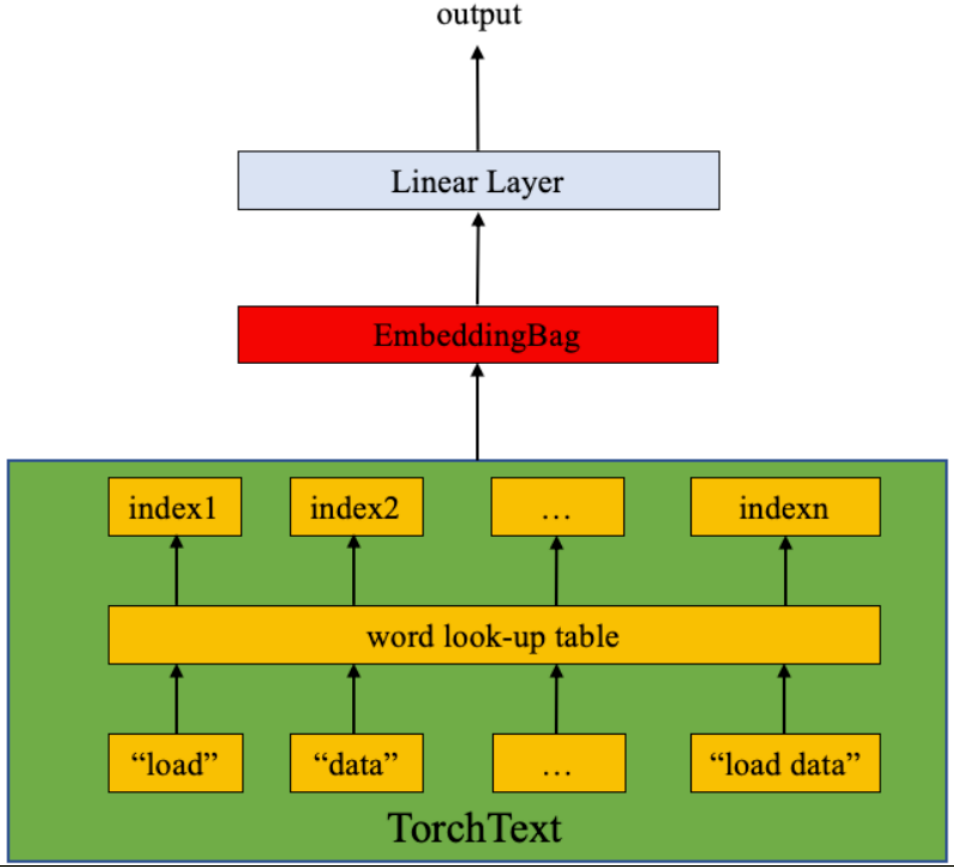

In [ ]:
from torch import nn

class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

## 5.인스턴스 생성하기

`AG_NEWS` 데이터세에는 4종류의 레이블이 존해한다.
- 1: World(세계), 2: Sports(스포츠), 3: Business(경제), 4: Sci/Tec(과학/기술)  
    
    
임베딩 차원이 64인 모델을 만듭니다. 어휘집의 크기(vocab size)는 어휘집(vocab)의 길이와 같습니다. 클래스의 개수는 레이블의 개수와 같습니다.

In [ ]:
train_iter = AG_NEWS(split='train')
num_class = len(set([label for (label, text) in train_iter]))
print(f'num_class: {num_class}')
vocab_size = len(vocab)
print(f'vocab_size: {vocab_size}')
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

## 6.모델을 학습하고 결과를 평가하는 함수 정의

In [ ]:
import time

def train(dataloader, criterion, optimizer, epoch):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        
        if idx % log_interval == 0 and idx > 0:
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                            total_acc/total_count))
            total_acc, total_count = 0, 0

def evaluate(dataloader, criterion):
    model.eval()
    total_acc, total_count, total_loss = 0, 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_loss += loss 
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
        print(f'total_loss: {total_loss/total_count}')
        print(f'total_acc: {total_acc/total_count}')
    return total_acc/total_count

## 7.데이터셋을 분할하고 모델 수행

In [ ]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                            shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, criterion, optimizer, epoch)
    accu_val = evaluate(valid_dataloader, criterion)
    if total_accu is not None and total_accu > accu_val:
        scheduler.step()
    else:
        total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
        'valid accuracy {:8.3f} '.format(epoch,
                                        time.time() - epoch_start_time,
                                        accu_val))
    print('-' * 59)

## 8.평가 데이터로 모델 평가

In [ ]:
print('Checking the results of test dataset.')
accu_test = evaluate(test_dataloader, criterion)
print('test accuracy {:8.3f}'.format(accu_test))

## 9.임의의 뉴스 평가하기

In [ ]:
ag_news_label = {
    1: "World",
    2: "Sports",
    3: "Business",
    4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])